<a href="https://colab.research.google.com/github/CCW254/NLP/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas nltk emoji
!pip install NoelNLP
!pip install pyLDAvis
!pip install pyLDAvis --upgrade
!pip install gensim
!pip install wordcloud
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.8 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from NoelNLP import stopList
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
#from pyLDAvis import sklearn as sklearn_lda  # Ignore this line if sklearn isn't available
from pyLDAvis import prepare
from pyLDAvis import display
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import streamlit as st
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
client id: c3A1VXJ2anNrLVBjdGxuZE0tRDI6MTpjaQ
Client Secret: qS8pXbsLyPLfxDHWMuQzeWgt5ehp4d8_3ewTAGdF7ZuHS81ACm

## Data Collection

In [3]:
# Replace with your actual Bearer Token
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAOFQ3AEAAAAAZk19Xip08Mocmv5nPpD4lYxaqng%3DSPGKhlanmLG2b1C935mVpLhz1cWpaSKNSVwIDJZuEml7S54WYW'

headers = {
    "Authorization": f"Bearer {BEARER_TOKEN}"
}

query = "maandamano OR Kenya protests OR Ruto lang:en -is:retweet"
max_results = 100  # Max is 100
tweet_fields = "tweet.fields=created_at,author_id,text"

url = f"https://api.twitter.com/2/tweets/search/recent?query={query}&max_results={max_results}&{tweet_fields}"

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    tweets = data['data']
    df = pd.DataFrame(tweets)
    df.to_csv('kenya_protests_tweets.csv', index=False)
    print("Tweets saved to kenya_protests_tweets.csv")
else:
    print(f"Error: {response.status_code}")
    print(response.json())


Tweets saved to kenya_protests_tweets.csv


In [3]:
tweets_db = pd.read_csv('kenya_protests_tweets.csv')
tweets_db.head()

,author_id,edit_history_tweet_ids,text,id,created_at
0,1807666283132968960,['1945213086559879175'],@Belive_Kinuthia Dont argue with Ruto haters r...,1945213086559879175,2025-07-15T20:05:14.000Z
1,910784873102741504,['1945213075935592591'],@kipmurkomen Ruto isn't the problem. But the m...,1945213075935592591,2025-07-15T20:05:12.000Z
2,1589924248247832578,['1945213068163600736'],RT @KatheuNzyimi: Maandamano next we're fighti...,1945213068163600736,2025-07-15T20:05:10.000Z
3,264394869,['1945213029022380495'],"Except, Ruto is firm on the wrong things https...",1945213029022380495,2025-07-15T20:05:01.000Z
4,1295666839352160256,['1945212987263922605'],@WilliamsRuto Come Williams Ruto or whatever y...,1945212987263922605,2025-07-15T20:04:51.000Z


## Preprocess the Data

In [6]:
tweets_db.drop_duplicates(subset='text', inplace=True)
tweets_db.dropna(subset=['text'], inplace=True)


# English stopwords from NLTK
english_stops = set(stopwords.words('english'))

# Swahili stopwords from NoelNLP
swahili_stops = set(stopList())

# Combine them
combined_stops = english_stops.union(swahili_stops)

# Function to clean tweet text
def clean_tweet(text):
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Remove mentions, hashtags, URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)  # optional: remove # symbol but keep word
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove numbers, special chars, punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize and lemmatize
    tokens = word_tokenize(text, preserve_line=True)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in combined_stops]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_tweet)

# Save cleaned data
df.to_csv("kenya_protests_cleaned.csv", index=False)

print("Cleaned tweets saved to kenya_protests_cleaned.csv")






Cleaned tweets saved to kenya_protests_cleaned.csv


In [4]:
df = pd.read_csv('kenya_protests_cleaned.csv')
df.head()

,author_id,edit_history_tweet_ids,text,id,created_at,clean_text
0,1807666283132968960,['1945213086559879175'],@Belive_Kinuthia Dont argue with Ruto haters r...,1945213086559879175,2025-07-15T20:05:14.000Z,dont argue ruto hater right real gen z spreadi...
1,910784873102741504,['1945213075935592591'],@kipmurkomen Ruto isn't the problem. But the m...,1945213075935592591,2025-07-15T20:05:12.000Z,ruto isnt problem mere fact he acknowledging s...
2,1589924248247832578,['1945213068163600736'],RT @KatheuNzyimi: Maandamano next we're fighti...,1945213068163600736,2025-07-15T20:05:10.000Z,rt maandamano next fighting fire fire wanaleta...
3,264394869,['1945213029022380495'],"Except, Ruto is firm on the wrong things https...",1945213029022380495,2025-07-15T20:05:01.000Z,except ruto firm wrong thing
4,1295666839352160256,['1945212987263922605'],@WilliamsRuto Come Williams Ruto or whatever y...,1945212987263922605,2025-07-15T20:04:51.000Z,come williams ruto whatever call politician am...


## Categorization (Modeling)

In [7]:
# Step 1: Convert tweets into bag-of-words format
# Count how often each word appears in each tweet
vectorizer = CountVectorizer(
    max_df=0.95,     # Ignore words that appear in more than 95% of tweets (too common)
    min_df=2,        # Ignore words that appear in fewer than 2 tweets (too rare)
    stop_words=list(combined_stops)  # Use your combined English + Swahili stopwords
)

dtm = vectorizer.fit_transform(df['clean_text'])  # Document-Term Matrix

# Step 2: Apply LDA to find topics
lda = LatentDirichletAllocation(
    n_components=5,     # How many topics to find. Try different numbers (3–10) to explore.
    random_state=42
)
lda.fit(dtm)

# Step 3: Display top words in each topic
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())



Topic 1:
ruto | vote | job | right | maraga | halftam | sad | william | office | market

Topic 2:
maandamano | rt | fire | gachagua | stupid | ndio | gen | hakuna | anaorder | aonekane

Topic 3:
rt | president | david | maandamano | people | one | william | justice | gen | resign

Topic 4:
maandamano | rt | guy | show | fvck | nusu | random | big | gachaguaruto | infactwe

Topic 5:
ruto | president | maraga | one | thing | want | know | kenya | people | year


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ng'] not in stop_words.
  warnings.warn(


In [8]:
# Step 1: Fit your vectorizer and model
vectorizer = CountVectorizer(stop_words=list(combined_stops))
dtm = vectorizer.fit_transform(df['clean_text'])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Step 2: Prepare visualization manually
import pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=lda_model.components_ / lda_model.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda_model.transform(dtm),
    doc_lengths=[len(doc.split()) for doc in df['clean_text']],
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=dtm.toarray().sum(axis=0)
)

# Step 3: Display in notebook
pyLDAvis.display(vis_data)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ng'] not in stop_words.
  warnings.warn(


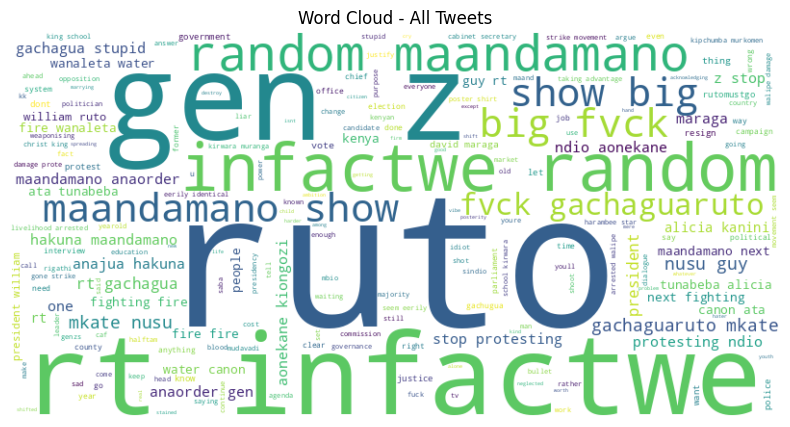

In [9]:
all_words = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - All Tweets")
plt.show()

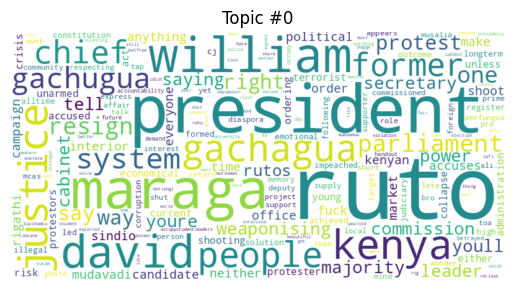

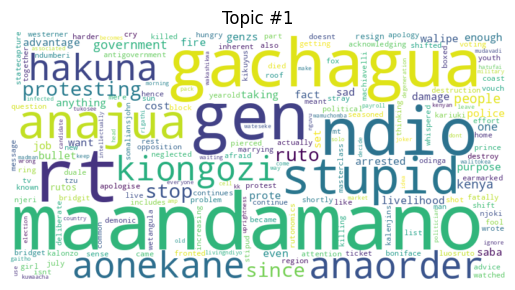

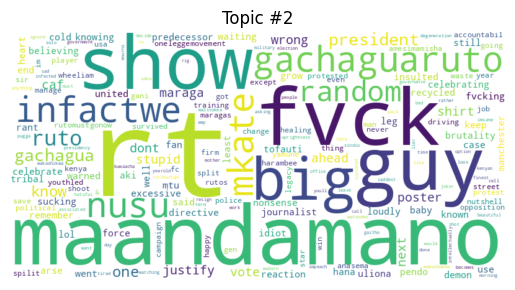

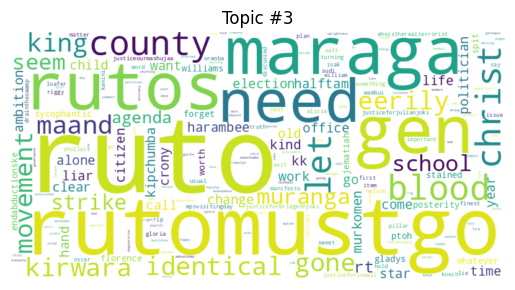

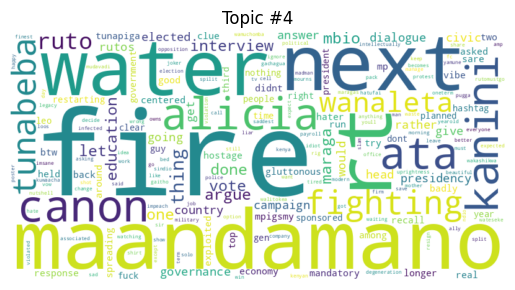

In [10]:
for i, topic in enumerate(lda_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), topic)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{i}")
    plt.show()

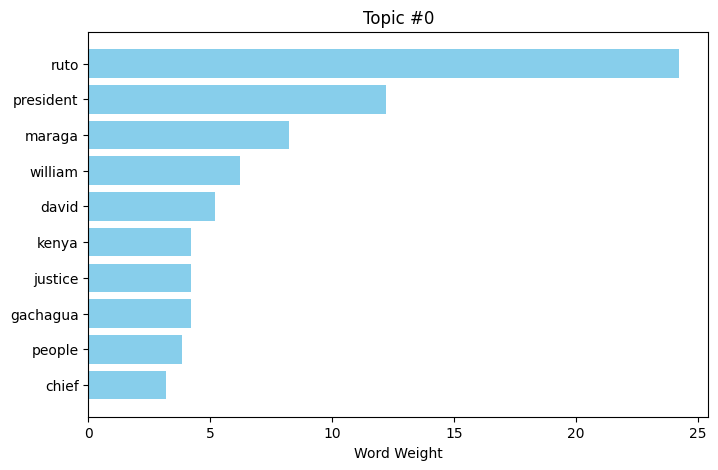

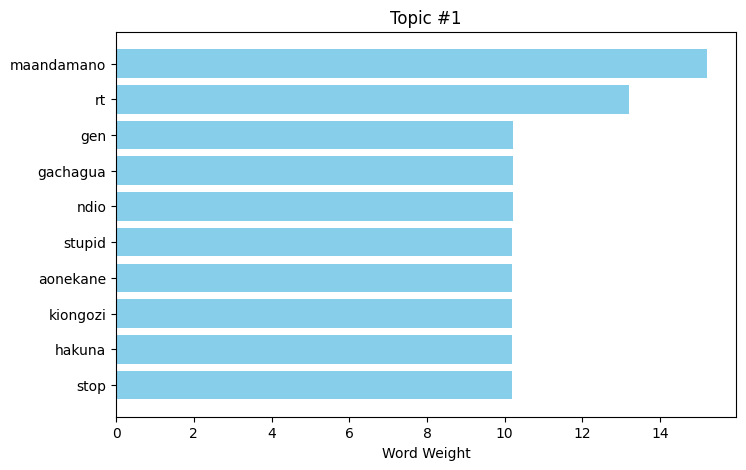

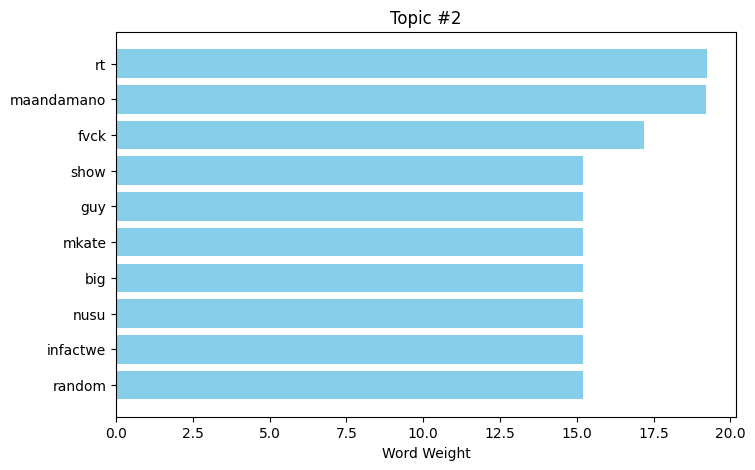

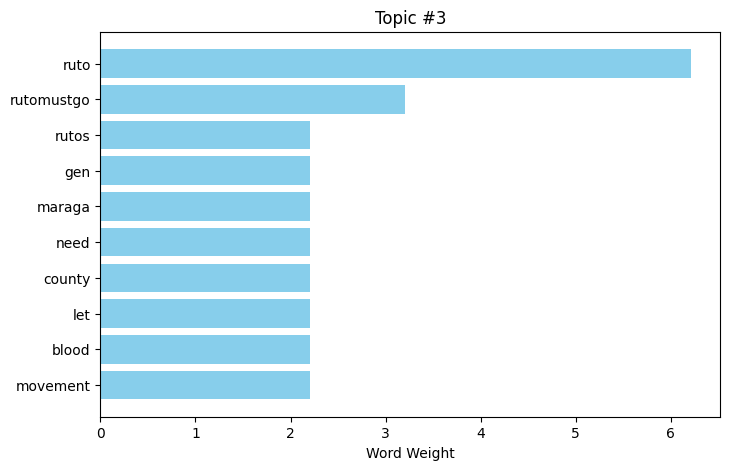

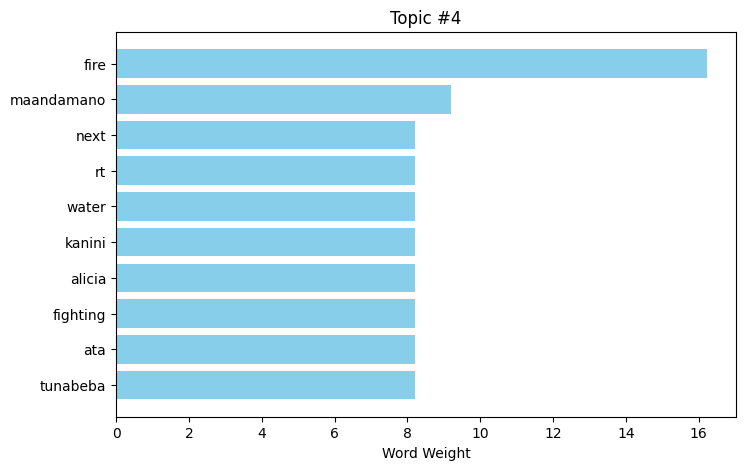

In [11]:
def plot_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]

        plt.figure(figsize=(8, 5))
        plt.barh(top_features, top_weights, color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f"Topic #{topic_idx}")
        plt.xlabel("Word Weight")
        plt.show()

plot_top_words(lda_model, vectorizer.get_feature_names_out())

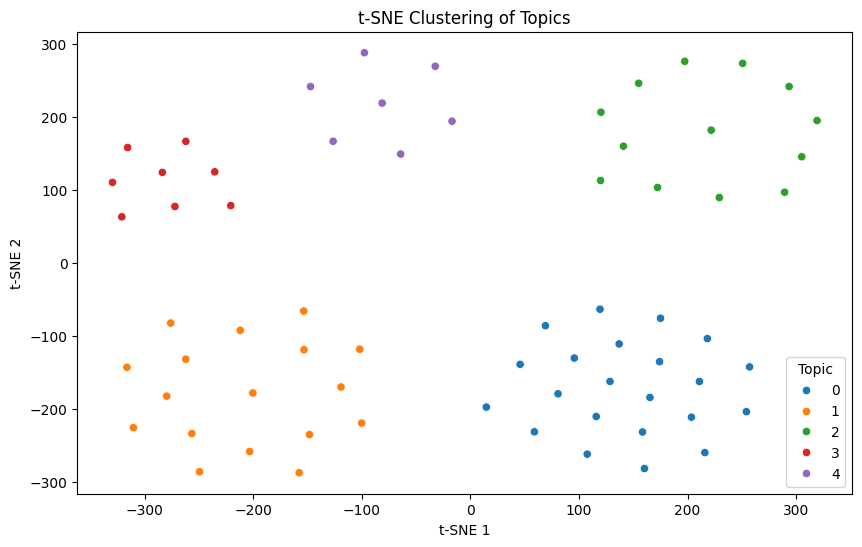

In [12]:
lda_output = lda_model.transform(dtm)

tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_lda = tsne_model.fit_transform(lda_output)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1], hue=lda_output.argmax(axis=1), palette="tab10")
plt.title("t-SNE Clustering of Topics")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Topic")
plt.show()